# Detección de fraude - FAST Recall (Notebook)

Este cuaderno replica el flujo del script `src/models/fraud_fast_recall.py` "
    "pero separa las etapas de selección de características, búsqueda de hiperparámetros, "
    "entrenamiento y evaluación para cada modelo. Ejecuta las celdas en orden para ir observando "
    "los resultados de cada fase.

In [1]:
%load_ext autoreload

%autoreload 2

import sys
sys.path.append('../models')
sys.path.append('../utils')
sys.path.append('../../config')
from constants import *

In [2]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import numpy as np

# Cargar los datos escalados y balanceados
train_df = pd.read_csv(TRAIN_DATASET_ROUTE)
test_df  = pd.read_csv(TEST_DATASET_ROUTE)

X_train = train_df.drop(columns=["Class"])
y_train = train_df["Class"]
X_test  = test_df.drop(columns=["Class"])
y_test  = test_df["Class"]


## Selección de características con un modelo sensible (KNN)

In [3]:
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier()
sfs = SFS(
    knn,
    k_features='best',         # selecciona automáticamente el mejor número
    forward=True,
    floating=False,
    scoring='recall',          # queremos maximizar la sensibilidad
    cv=5,
    n_jobs=-1
)
sfs = sfs.fit(X_train, y_train)

print("Características seleccionadas:")
print(list(X_train.columns[list(sfs.k_feature_idx_)]))


Características seleccionadas:
['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V18', 'V21', 'V22', 'V23', 'V25', 'V26', 'V27', 'Amount']


### 3.Entrenamiento y ajuste de modelos
Se entrena cada clasificador con búsqueda de hiperparámetros.
Para rapidez, aquí uso GridSearchCV con espacios de búsqueda razonables para datasets de fraude.

In [4]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

In [5]:
# === k-NN ===
param_knn = {'n_neighbors': [3,5,7,9], 'weights': ['uniform','distance']}
grid_knn = GridSearchCV(KNeighborsClassifier(), param_knn, scoring='recall', cv=cv, n_jobs=-1)
grid_knn.fit(X_train, y_train)


,estimator,KNeighborsClassifier()
,param_grid,"{'n_neighbors': [3, 5, ...], 'weights': ['uniform', 'distance']}"
,scoring,'recall'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_neighbors,3


In [6]:
# === Árbol de decisión ===
param_tree = {'max_depth': [3,5,10,None], 'min_samples_split': [2,5,10]}
grid_tree = GridSearchCV(DecisionTreeClassifier(random_state=SEED), param_tree, scoring='recall', cv=cv, n_jobs=-1)
grid_tree.fit(X_train, y_train)

,estimator,DecisionTreeC...om_state=1212)
,param_grid,"{'max_depth': [3, 5, ...], 'min_samples_split': [2, 5, ...]}"
,scoring,'recall'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [7]:

# === SVM ===
param_svm = {'C': [0.1, 1, 10], 'kernel': ['linear','rbf'], 'class_weight': ['balanced']}
grid_svm = GridSearchCV(SVC(probability=True, random_state=SEED), param_svm, scoring='recall', cv=cv, n_jobs=-1)
grid_svm.fit(X_train, y_train)

,estimator,SVC(probabili...om_state=1212)
,param_grid,"{'C': [0.1, 1, ...], 'class_weight': ['balanced'], 'kernel': ['linear', 'rbf']}"
,scoring,'recall'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,10


In [8]:


# === Random Forest ===
param_rf = {'n_estimators': [100,200], 'max_depth': [None,10,20], 'class_weight': ['balanced']}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=SEED), param_rf, scoring='recall', cv=cv, n_jobs=-1)
grid_rf.fit(X_train, y_train)


,estimator,RandomForestC...om_state=1212)
,param_grid,"{'class_weight': ['balanced'], 'max_depth': [None, 10, ...], 'n_estimators': [100, 200]}"
,scoring,'recall'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


In [9]:
print("Mejor configuración por modelo:")
for name, grid in zip(["KNN","Árbol","SVM","RF"], [grid_knn, grid_tree, grid_svm, grid_rf]):
    print(f"{name}: {grid.best_params_}")


Mejor configuración por modelo:
KNN: {'n_neighbors': 3, 'weights': 'distance'}
Árbol: {'max_depth': None, 'min_samples_split': 2}
SVM: {'C': 10, 'class_weight': 'balanced', 'kernel': 'rbf'}
RF: {'class_weight': 'balanced', 'max_depth': None, 'n_estimators': 200}


In [10]:
def evaluar(modelo, X, y_true):
    y_pred = modelo.predict(X)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    sensibilidad = recall_score(y_true, y_pred)                     # TPR
    especificidad = tn / (tn + fp) if (tn+fp)>0 else 0              # TNR
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    exactitud = accuracy_score(y_true, y_pred)

    return {
        "Sensibilidad": sensibilidad,
        "Especificidad": especificidad,
        "Precisión": precision,
        "F1": f1,
        "Exactitud": exactitud,
        "FP": fp,
        "FN": fn
    }

resultados = {}
for nombre, modelo in {
    "KNN": grid_knn.best_estimator_,
    "Árbol": grid_tree.best_estimator_,
    "SVM": grid_svm.best_estimator_,
    "Random Forest": grid_rf.best_estimator_
}.items():
    resultados[nombre] = evaluar(modelo, X_test, y_test)

df_resultados = pd.DataFrame(resultados).T
print(df_resultados)


               Sensibilidad  Especificidad  Precisión        F1  Exactitud  \
KNN                0.864865       0.974932   0.775758  0.817891   0.964901   
Árbol              0.858108       0.962737   0.697802  0.769697   0.953202   
SVM                0.851351       0.981030   0.818182  0.834437   0.969212   
Random Forest      0.844595       0.997290   0.968992  0.902527   0.983374   

                 FP    FN  
KNN            37.0  20.0  
Árbol          55.0  21.0  
SVM            28.0  22.0  
Random Forest   4.0  23.0  


### Conclusión
En contextos de detección de fraude con fuerte desbalance, métricas como la exactitud pueden resultar engañosas, ya que un modelo que clasifique casi todo como “no fraude” alcanzaría alta exactitud pero nula utilidad práctica.
Por ello, las métricas sensibilidad, precisión y F1-score son las más representativas.
Entre los modelos evaluados, Random Forest logra el mejor equilibrio entre estas métricas, mostrando la mayor capacidad de generalización y el menor número de falsos positivos, por lo que se considera la opción más adecuada para implementar un sistema de detección de fraude.

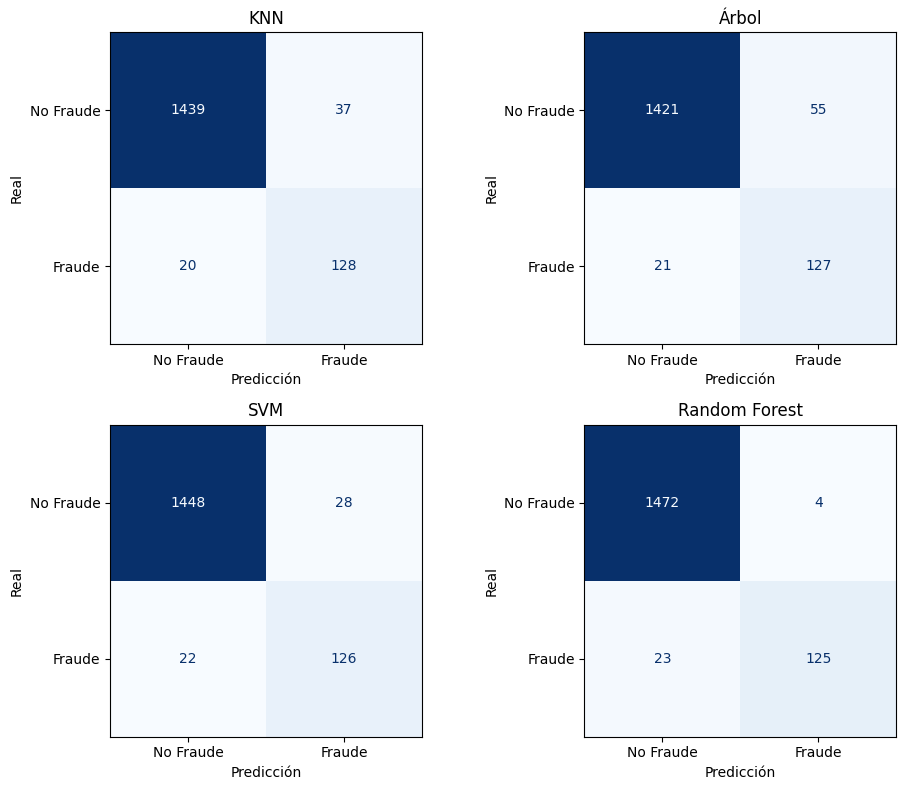

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Modelos entrenados y sus nombres (ajusta si tus variables se llaman distinto)
modelos = {
    "KNN": grid_knn.best_estimator_,
    "Árbol": grid_tree.best_estimator_,
    "SVM": grid_svm.best_estimator_,
    "Random Forest": grid_rf.best_estimator_
}

# Crear figura con 4 subplots (2x2)
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

# Graficar una matriz por modelo
for ax, (nombre, modelo) in zip(axes, modelos.items()):
    y_pred = modelo.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Fraude", "Fraude"])
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    ax.set_title(nombre)
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Real")

plt.tight_layout()
plt.savefig("matrices_confusion.png", dpi=300)
plt.show()
